In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


In [2]:
df=pd.read_csv('song_data.csv')
df.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [3]:
# Remove the categorical data
numeric_df = df.drop(columns=['song_name'])
numeric_df

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18830,60,159645,0.893000,0.500,0.151,0.000065,11,0.1110,-16.107,1,0.0348,113.969,4,0.300
18831,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.265
18832,23,182211,0.847000,0.719,0.325,0.000000,0,0.1250,-12.222,1,0.0355,130.534,4,0.286
18833,55,352280,0.945000,0.488,0.326,0.015700,3,0.1190,-12.020,1,0.0328,106.063,4,0.323


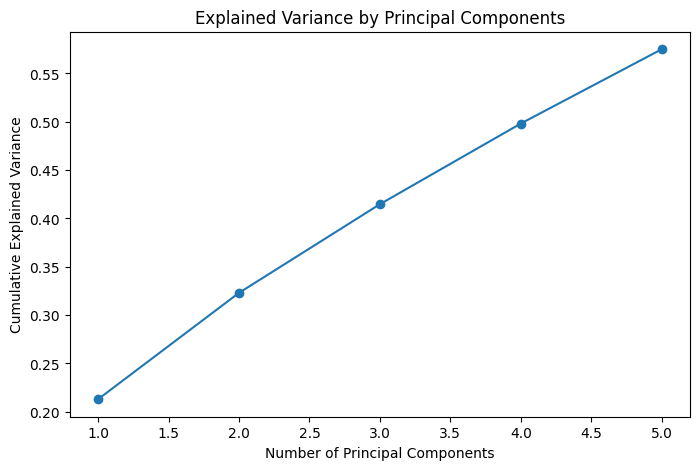

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
PC1,0.035963,-0.460860,0.196477,0.518309,-0.275464,0.023531,0.107224,0.511300,-0.070278,0.122259,0.125289,0.164016,0.259276
PC2,-0.342590,0.147114,0.612764,-0.217340,-0.080782,0.132030,-0.218057,-0.112579,-0.221445,0.306275,-0.283276,0.160627,0.324353
PC3,-0.130929,0.058100,0.115565,-0.014005,-0.175082,-0.558237,-0.180238,0.029853,0.630817,-0.315963,-0.116203,0.074903,0.270916
PC4,-0.465735,0.076056,-0.054656,-0.056662,-0.005290,-0.250160,0.466777,-0.035421,0.207473,0.551179,0.361174,-0.053423,-0.096026
PC5,0.338315,-0.128222,0.100746,-0.019336,0.211993,-0.395715,0.278903,-0.079716,-0.072968,0.191596,-0.405039,0.543318,-0.267623


In [4]:
# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(numeric_df.drop(columns=['song_popularity']))

# Apply PCA
pca = PCA(n_components=5)  # Specify the number of components you want
pca_result = pca.fit_transform(normalized_data)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), explained_variance.cumsum(), marker='o')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Determine feature importance
loadings = pd.DataFrame(pca.components_, columns=numeric_df.columns[1:], index=[f'PC{i+1}' for i in range(len(pca.components_))])
loadings

In [5]:
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.21294732 0.11004165 0.09171698 0.08345686 0.07688449]


As the result shown, the first five principal components capture approximately 54.22% of the total variance in the data 

## <u>What PCA can tell us</u>
* What is the vector that represents a particular combination of travel rating preferences that describes the highest amount of variability in the dataset?
* What is the vector that represents a particular combination of travel rating preferences that describes the second highest amount of variability in the dataset?
* The third highest amount of data variability?
* How many vectors do we need to describe *most* of the total variance of the original 10 attributes?
* How important is each of these new attribute vectors to a given object in the dataset?


In [6]:
correlations = numeric_df.corr()
print(correlations['song_popularity'].sort_values(ascending=False))

song_popularity     1.000000
danceability        0.104290
loudness            0.099442
time_signature      0.034983
speechiness         0.021479
energy              0.001365
audio_mode         -0.004969
key                -0.013160
song_duration_ms   -0.018899
tempo              -0.022672
liveness           -0.038937
audio_valence      -0.052895
acousticness       -0.065181
instrumentalness   -0.130907
Name: song_popularity, dtype: float64


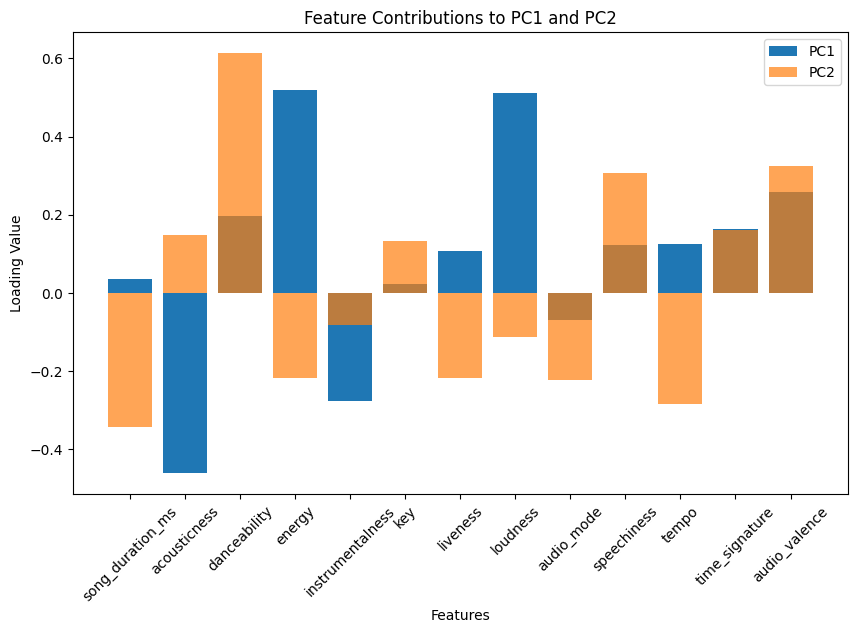

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(loadings.columns, loadings.loc['PC1'], label='PC1')
plt.bar(loadings.columns, loadings.loc['PC2'], label='PC2', alpha=0.7)
plt.xticks(rotation=45)
plt.title('Feature Contributions to PC1 and PC2')
plt.xlabel('Features')
plt.ylabel('Loading Value')
plt.legend()
plt.show()


In [8]:
# Use retained PCs as predictors
retained_pcs = pca_result  
reg = LinearRegression()
reg.fit(retained_pcs, numeric_df['song_popularity'])

print("Regression coefficients for PCs:", reg.coef_)


Regression coefficients for PCs: [ 0.99017513  1.05948105  0.58746818 -0.2789319   0.39312763]


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Assume target variable is 'popularity_category' (binary or multiclass)
target = df['song_popularity']

# Split the PCA-reduced dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(pca_result, target, test_size=0.2, random_state=42)

# Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print("Model Accuracy:", accuracy)


Model Accuracy: 0.2933368728431112
